In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Subtract, Dot
from tensorflow.keras.models import Model
from data_preparation import create_dataset, get_size
import math


## Loading Data
First, we need to load the data. Our X file contains word embedding of a query. all queries are resized to contain 42 phrases (shorter queries are zero-padded - this 42 is not a good size, most of queries are padded more than there is phrases), and each phrase is represented by a 200 dim embedding. so our X's are `dataset_size * 42 * 200` vectors.

`Y` is indicating whether this vector was a `bad`, `neutral` or `good` query. So it is of size `3`

Download data files from [here](https://drive.google.com/drive/folders/18iHWo-gI4_IpNk7bkqvcbWGGDMQkLlVN?usp=sharing)

In [3]:

X = np.load('./dataset/train/x.npy', mmap_mode='r')
Y = np.load('./dataset/train/y.npy', mmap_mode='r')

# if set to True, labels will be in one-hot encodded format and output of neural network will be a 2 neuron dense layer with softmax activation to match it
ONE_HOT=False 
dataset = create_dataset((X,Y.argmax(axis=1)), [0,1,2], one_hot=ONE_HOT)
DATASET_SIZE = get_size(dataset)
# def convert(ds):
#     return {'input_1': ds[0], 'input_2': ds[1]}, ds[2]
# dataset = dataset.apply(convert)
# print_size(dataset)
print(dataset)
print(DATASET_SIZE)
# tfds.benchmark(dataset)

<ConcatenateDataset shapes: (((42, 200), (42, 200)), ()), types: ((tf.float64, tf.float64), tf.int32)>
70507


## Siamese Network
`Siamese Network` are usually used for one-shot classification, or comparing instances of data in computer vision. There are two sister network in them which works as a feature extraction phase. The network is fed two (or more) instances of data, let's say `x1` and `x2`. These two inputs go through the same network (on of the 'sisters') and the result of them are then subtracted (or any other function, like euclidean distance or whatever else) and the output of this subtraction layer is given to a dense network to decide whether they are of the same class. For example one of the main uses of siamese networks are in face recognition when you want to find similarity between your faces.
![alt text](.\img\capture.PNG  "Siamese Network")

Here we first create our sister networks using Conv1D, then subtract the result of these two `feature extractors` and give the subtraction result to a dense layer to learn if they are similar or not.

In [4]:

def build_siamese_model(inputShape, output_shape = 64):
    regulizer =tf.keras.regularizers.l2( l=0.01)
    input = Input(shape=inputShape)
    text_layer = Conv1D(256, 5, activation='relu', kernel_regularizer=regulizer)(input)
    text_layer = Dropout(0.2)(text_layer)
    text_layer = MaxPooling1D(3)(text_layer)
    text_layer = Conv1D(256, 3, activation='relu',kernel_regularizer=regulizer)(text_layer)
    text_layer = Dropout(0.2)(text_layer)
    text_layer = MaxPooling1D(3)(text_layer)
    text_layer = GlobalMaxPooling1D()(text_layer)
    text_layer = Dense(256, activation='relu')(text_layer)
    output_layer = Dense(output_shape, activation='relu')(text_layer)
    model = Model(input, output_layer)
    model.summary()
    return model
input_shape = X.shape[1:]
txtA = Input(shape=input_shape, name='input_1')
txtB = Input(shape=input_shape, name='input_2')
featureExtractor  = build_siamese_model(input_shape)
featsA = featureExtractor(txtA)
featsB = featureExtractor(txtB)
distance = Subtract()([featsA, featsB])
distance = Dot(axes=(1,1), normalize=True)([featsA, featsB])
distance = Dense(32, activation="relu")(distance)
if ONE_HOT:
    outputs = Dense(2, activation="softmax")(distance)
else:
    outputs = Dense(1, activation='sigmoid')(distance)
model = Model(name= 'model',inputs=(txtA, txtB), outputs=outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 42, 200)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 38, 256)           256256    
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 256)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 256)           196864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 256)            0   

In [5]:
def fit_model(model, ds, val_split = 0.1,batch_size = 128, **kwargs):
  optimizers = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.0, nesterov=False, name="SGD"
  )
  model.compile(optimizer=optimizers,
              loss='binary_crossentropy',
              metrics=['acc'])
  ds = ds.shuffle(batch_size).repeat()
  val_size = round(val_split * DATASET_SIZE)
  train_size = round((1 - val_split) * DATASET_SIZE)
  val_ds = ds.take(val_size).shuffle(batch_size * 2).batch(min(val_size, BATCH_SIZE))
  train_ds = ds.skip(val_size).batch(batch_size)
  train_steps = math.ceil(train_size // batch_size)
  val_step = max(val_size // batch_size, 1)
  return model.fit(train_ds, steps_per_epoch=train_steps ,validation_data=val_ds,validation_steps=val_step,**kwargs)


In [6]:
BATCH_SIZE = 32

history = fit_model(model, dataset, val_split=0.2, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
1762/1762 [==============================] - 310s 165ms/step - loss: 3.9319 - acc: 0.8090 - val_loss: 3.6845 - val_acc: 0.3215
Epoch 2/20
1762/1762 [==============================] - 250s 142ms/step - loss: 3.0387 - acc: 0.8039 - val_loss: 2.8965 - val_acc: 0.6785
Epoch 3/20
1762/1762 [==============================] - 256s 146ms/step - loss: 2.0610 - acc: 0.7998 - val_loss: 2.3693 - val_acc: 0.3215
Epoch 4/20
1762/1762 [==============================] - 268s 152ms/step - loss: 1.2851 - acc: 0.7765 - val_loss: 1.4033 - val_acc: 0.3215
Epoch 5/20
1762/1762 [==============================] - 270s 153ms/step - loss: 0.8813 - acc: 0.7815 - val_loss: 1.3045 - val_acc: 0.3215
Epoch 6/20
1762/1762 [==============================] - 275s 156ms/step - loss: 0.6314 - acc: 0.8203 - val_loss: 1.6193 - val_acc: 0.3215
Epoch 7/20
1762/1762 [==============================] - 275s 156ms/step - loss: 0.6286 - acc: 0.7527 - val_loss: 0.7477 - val_acc: 0.6785
Epoch 8/20
1762/1762 [============

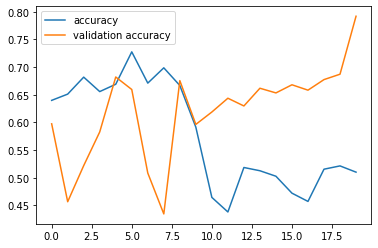

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy','validation accuracy'])

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# from sklearn.metrics import ConfusionMatrixDisplay

# y_pred = model.predict(X_t)
# y_pred
# cm = confusion_matrix(Y_t.argmax(axis=1), y_pred.argmax(axis=1))

# display_labels = ['Bad', 'Neutral', 'Good']
# df_cm = pd.DataFrame(cm,index=display_labels, columns=display_labels)

# # plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
# plt.figure(figsize = (15,12))

# # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               # display_labels=display_labels)
# # disp = disp.plot(include_values=True,
#                 #  cmap='viridis', ax=None, xticks_rotation='horizontal')
# plt.show()
# # print('recall', tp / (tp + fn))
# # print('precision', tp / (tp + fp))
# # print('acc', tp + tn / (tp + tn + fp + fn))

In [ ]:
model.save('/content/drive/MyDrive/Uni/Thesis/query_formulation_deepnn/models/simple_cnn_model')